# Dataset

The **Sketchy dataset** is a collection of sketch-photo pairs. It contains 12'500 photos of objects sampled across 125 categories, such as "airplane," "guitar," and "cat." Each photo is associated with 5 or more independently drawn sketches, resulting in a total of 75'471 sketches. The dataset serves as a foundation for crossmodal metric learning, where the goal is to model the relationship between abstract line drawings and real-world visual content.

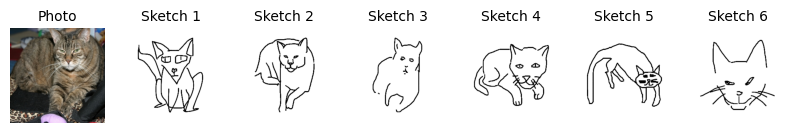

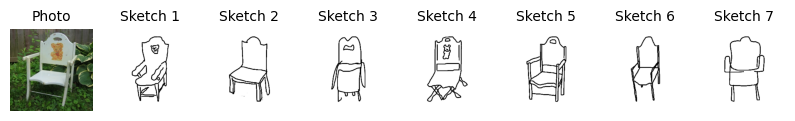

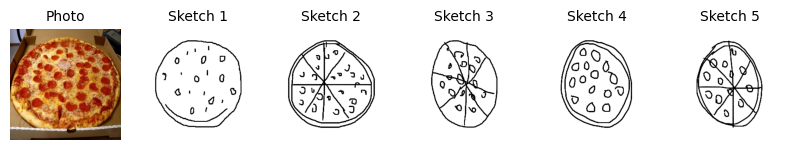

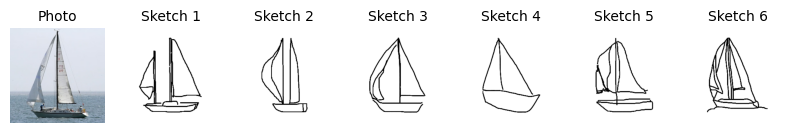

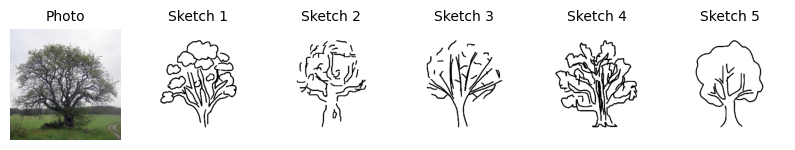

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = Path('.data')
photo_dir = data_dir / 'photo'
sketch_dir = data_dir / 'sketch'

categories = ['cat', 'chair', 'pizza', 'sailboat', 'tree']

for category in categories:
    photo_category_dir = photo_dir / category
    sketch_category_dir = sketch_dir / category

    photo_file = list(photo_category_dir.glob('*.jpg'))[0]
    photo_id = photo_file.stem
    
    photo = Image.open(photo_file)
    sketches = []

    for sketch_file in sketch_category_dir.glob(f'{photo_id}-*.png'):
        sketch = Image.open(sketch_file)
        sketches.append(sketch)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, len(sketches) + 1, 1)
    plt.imshow(photo)
    plt.axis('off')
    plt.title('Photo', fontsize=10)
    for i, sketch in enumerate(sketches):
        plt.subplot(1, len(sketches) + 1, i + 2)
        plt.imshow(sketch)
        plt.axis('off')
        plt.title(f'Sketch {i + 1}', fontsize=10)

## Download and organize the images

Follow these steps to download the dataset and organize it into a proper folder structure.

- Download the images from [here](https://drive.google.com/file/d/1z4--ToTXYb0-2cLuUWPYM5m7ST7Ob3Ck/view).

- In the `photo` folder, there are two subfolders that contain the same images resized to 256x256.
  - `tx_000000000000`: Non-uniform scaling of the full image to 256×256 pixels.
  - `tx_000100000000`: Cropped bounding box of the object, scaled to 256×256, but with a +10% margin.

- In the `sketch` folder, there are several subfolders that contain the same sketches resized to a 256x256 canvas.
  - `tx_000000000000`: Sketch is scaled non-uniformly to match its photo.
  - `tx_000100000000`: Sketch is centered and uniformly scaled, with its largest side filling 78% of the canvas.
  - `tx_000000000010`: Sketch is centered based on bounding box, then cropped to 256x256.
  - `tx_000000000110`: Sketch is centered on bounding box and uniformly scaled to fit the smaller side.
  - `tx_000000001010`: Sketch is centered on bounding box and uniformly scaled to fit the larger side.
  - `tx_000000001110`: Sketch is centered on bounding box and non-uniformly scaled to completely fit within the bounding box.

- Pick one subfolder for the photos and one subfolder for the sketches (e.g., `tx_000100000000`). Rename the chosen subfolders to `photo` and `sketch` respectively. Move them to a new folder (e.g., `.data`) within your project directory. Delete the unused subfolders of photos and sketches.

- Download the information files from [here](https://drive.google.com/file/d/1z4--ToTXYb0-2cLuUWPYM5m7ST7Ob3Ck/view). Copy the `info` folder into the `.data` folder.

At this point, your project directory should look like this:

```bash
project
│
├── .data
│   │
│   ├── info
│   │   ├── invalid-errors.txt
│   │   ├── invalid-ambiguous.txt
│   │   ├── testset.txt
│   │   └── ...
│   │   
│   ├── photo
│   │   ├── airplane
│   │   │   ├── n02691156_58.jpg
│   │   │   └── ...
│   │   ├── alarm_clock
│   │   │   ├── n02694662_92.jpg
│   │   │   └── ...
│   │   └── ...
│   │
│   └── sketch
│       ├── airplane
│       │   ├── n02691156_58-1.png
│       │   └── ...
│       ├── alarm_clock
│       │   ├── n02694662_92-1.png
│       │   └── ...
│       └── ...
```

## ImageDataset for photos and sketches

This section explains how to build a general-purpose dataset for loading images and their corresponding labels. You will use this class to build separate datasets for the photos and the sketches. To get you started, check out the code below, which implements the basic structure of the `ImageDataset` class. You will need to populate the `samples` list with tuples of the form `(path, label)` for each image in the dataset, as explained further below.

```python
from PIL import Image
from torch.utils.data import Dataset

class ImageDataset(Dataset):

    def __init__(self, transform=None):
        self.transform = transform
        self.samples = []  # list of tuples (path, label)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label
```

### Gather image paths and labels

To populate the `samples` list of an ImageDataset, you need to iterate recursively through the directory `.data/photo` or `.data/sketch` depending on which dataset you are building. You can use the `os` or `pathlib` library to traverse the subfolders and gather the paths and labels. Consider the following points when implementing this.
- Each subfolder corresponds to a category, and the images within that subfolder belong to that category. The label for each image is thus the name of the subfolder it resides in.
- You must use integer labels for the categories, starting from 0. So you need to build a dictionary to map the category names to integer labels. The mapping should be the same for the photo and sketch datasets.

In the end, you should have a list of `(path, label)` tuples, where `path` is the full path to the image file and `label` is the integer label corresponding to its category.

### Apply a train/test split

The file `info/testset.txt` contains a list of photo IDs that are reserved for evaluation. When populating the `samples` list of your datasets:
- If you're preparing the training set, skip all photos and sketches associated with IDs in `testset.txt`
- If you're preparing the test set, include only those samples.

Each dataset instance should be created with a flag (e.g., `train=True`) that controls this filtering behavior. (By the way, this is the reason why you cannot use the standard `torchvision.datasets.ImageFolder` class, as it does not allow for such filtering.)

### Filter invalid sketches

Some sketches in the dataset are labeled as invalid due to errors, ambiguity, pose mismatch, or background context. You should filter out sketches listed in:
 - `info/invalid-error.txt`
 - `info/invalid-ambiguous.txt`

When building the sketch dataset, skip any image whose filename (without extension) appears in these files.

## PairDataset for sketch-photo pairs

This section explains how to build a dataset that loads pairs of images (sketch and photo) and their corresponding labels. You will use this class to create the training and test datasets for the crossmodal metric learning task. Specifically, the dataset is built as follows.
 - Each photo is paired with the sketches drawn from it (instance-level pairing).
 - Each pair is labeled with both its category label and a unique photo identifier.
 - Each sample is a tuple `(photo, sketch, class_label, photo_id)`.

To get you started, check out the code below, which implements the basic structure of the `PairDataset` class. You will need to populate the `pairs` list with a tuple for each sample in the dataset, as explained further below.

```python
from PIL import Image
from torch.utils.data import Dataset

class PairDataset(Dataset):

    def __init__(self, transform=None):
        self.transform = transform
        self.pairs = []

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        photo_path, sketch_path, class_label, photo_id = self.pairs[idx]
        photo = Image.open(photo_path).convert('RGB')
        sketch = Image.open(sketch_path).convert('RGB')
        if self.transform:
            photo = self.transform(photo)
            sketch = self.transform(sketch)
        return photo, sketch, class_label, photo_id
```

### Gather photo-sketch pairs and labels

To populate the `pairs` list of a PairDataset, you will need to find all valid matches between a photo and the sketches drawn from it. Note that each photo has a unique identifier encoded in its filename, and each sketch references that identifier in its own filename. For example:
 - Photo filename: `n02691156_58.jpg`
 - Sketch filenames: `n02691156_58-1.png`, `n02691156_58-2.png`, ..., `n02691156_58-5.png`

Based on this relationship, you can generate photo-sketch pairs by scanning the `.samples` list of the photo dataset and the `.samples` list of the sketch dataset. The procedure is as follows.

- **Group sketches by their photo ID**
  - Iterate over the `.samples` list of the sketch dataset.
  - Populate a dictionary where the keys are the photo IDs (e.g., `n02691156_58`), and the values are lists of sketch paths that correspond to that photo ID.

- **Create pairs**
    - Iterate over the `.samples` list of the photo dataset.
    - For each photo, extract its ID from the filename and look up its corresponding sketches in the dictionary created in the previous step.
    - For every sketch matched to a photo, append a tuple to the `pairs` list containing:
        - The path to the photo,
        - The path to the sketch,
        - The category label,
        - The photo ID.

Only photo-sketch pairs with a valid match are included. If a photo has no sketches (which should not happen in this dataset), it is skipped with a warning.

## Validation

If you have implemented the `ImageDataset` and `PairDataset` classes correctly, you should be able to instantiate three datasets: one for the photos, one for the sketches, and one for the pairs. You should get the following output for the training set.

Number of classes: 125
Number of photos: 11250
Number of sketches: 61732
Number of pairs: 61732


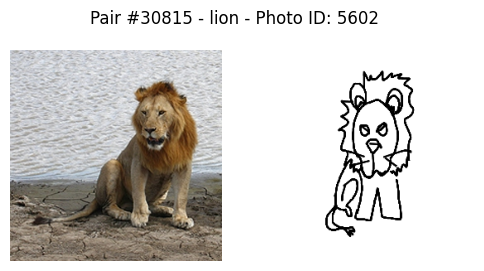

In [4]:
import matplotlib.pyplot as plt
import random
from solution.dataset import load_datasets

photo_ds, sketch_ds, pair_ds = load_datasets('.data', train=True)

print("Number of classes:", len(sketch_ds.classes))
print("Number of photos:", len(photo_ds))
print("Number of sketches:", len(sketch_ds))
print("Number of pairs:", len(pair_ds))

idx = random.randint(0, len(pair_ds) - 1)
photo, sketch, class_label, photo_id = pair_ds[idx]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(photo)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sketch)
plt.axis('off')
plt.suptitle(f"Pair #{idx} - {sketch_ds.classes[class_label]} - Photo ID: {photo_id}", fontsize=12)
plt.show()